Reducción de la dimensionalidad

In [19]:
# === Configuración de rutas ===
TRAIN_PATH = "../data/dataset/final/X_trained_scaled_final_no_cat.csv"  
TEST_PATH  = "../data/dataset/final/X_test_scaled_final_no_cat.csv"   
OUT_DIR    = "./output"                          
TARGET_VARIANCE = 0.95                             # 95% por defecto

In [20]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
import pickle

In [21]:
X_train = pd.read_csv(TRAIN_PATH)
X_test  = pd.read_csv(TEST_PATH)

In [22]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score


In [23]:
def analyze_missing_values(df):
    # Calcular valores faltantes
    missing_values = df.isnull().sum()
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    
    # Crear DataFrame con el análisis
    missing_info = pd.DataFrame({
        'Missing Values': missing_values,
        'Missing Percentage': missing_percentage.round(2)
    })
    
    # Ordenar por cantidad de valores faltantes (descendente)
    missing_info = missing_info.sort_values('Missing Values', ascending=False)
    
    # Mostrar solo columnas con al menos un valor faltante
    return missing_info[missing_info['Missing Values'] > 0]

# Analizar tanto el conjunto de entrenamiento como el de prueba
print("=== Missing Values en X_train ===")
display(analyze_missing_values(X_train))

print("\n=== Missing Values en X_test ===")
display(analyze_missing_values(X_test))

# Mostrar el total de valores faltantes
print("\nTotal de valores faltantes:")
print(f"X_train: {X_train.isnull().sum().sum():,}")
print(f"X_test: {X_test.isnull().sum().sum():,}")

=== Missing Values en X_train ===


,Missing Values,Missing Percentage



=== Missing Values en X_test ===


,Missing Values,Missing Percentage



Total de valores faltantes:
X_train: 0
X_test: 0


In [24]:

for df in (X_train, X_test):
    if df.columns[0].lower() in ("unnamed: 0", "index", ""):
        df.drop(df.columns[0], axis=1, inplace=True)
    df[:] = df.apply(pd.to_numeric, errors="coerce")

print("Shapes → train:", X_train.shape, " test:", X_test.shape)


Shapes → train: (5171, 1981)  test: (2195, 1981)


Componentes totales: 1981 | k seleccionado (≥95%): 552
Varianza acumulada con k=552: 0.9501


,component,explained_variance_ratio,cumulative_variance_ratio
0,1,0.104073,0.104073
1,2,0.026803,0.130876
2,3,0.022345,0.153221
3,4,0.019843,0.173064
4,5,0.018420,0.191485
5,6,0.014599,0.206084
6,7,0.013857,0.219941
7,8,0.013609,0.233549
8,9,0.013116,0.246665
9,10,0.012360,0.259025


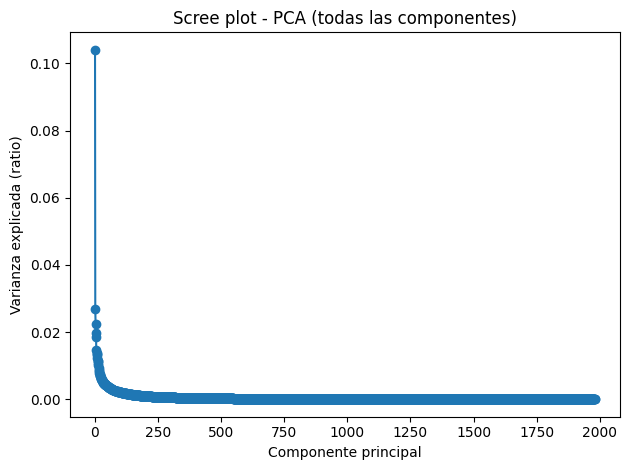

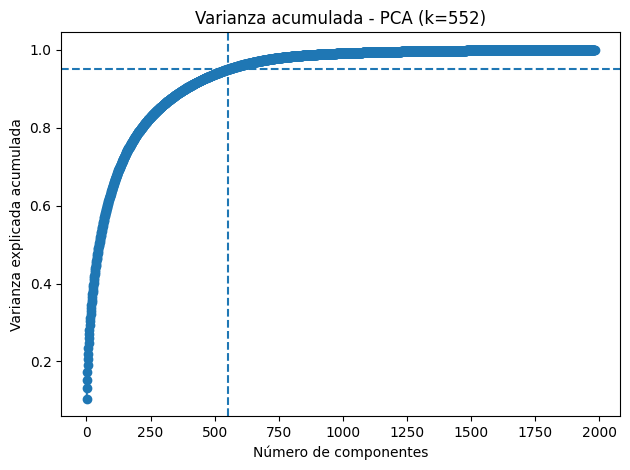

In [25]:
pca_full = PCA()
pca_full.fit(X_train.values)
explained_var = pca_full.explained_variance_ratio_
cum_explained = np.cumsum(explained_var)

# Selección de k (mínimo con ≥ TARGET_VARIANCE)
k = int(np.searchsorted(cum_explained, TARGET_VARIANCE) + 1)
print(f"Componentes totales: {len(explained_var)} | k seleccionado (≥{int(TARGET_VARIANCE*100)}%): {k}")
print(f"Varianza acumulada con k={k}: {cum_explained[k-1]:.4f}")

# Tabla de varianza explicada
var_table = pd.DataFrame({
    'component': np.arange(1, len(explained_var)+1),
    'explained_variance_ratio': explained_var,
    'cumulative_variance_ratio': cum_explained
})
display(var_table.head(25))

# Gráficos
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), explained_var, marker='o')
plt.xlabel('Componente principal')
plt.ylabel('Varianza explicada (ratio)')
plt.title('Scree plot - PCA (todas las componentes)')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(np.arange(1, len(cum_explained)+1), cum_explained, marker='o')
plt.axhline(y=TARGET_VARIANCE, linestyle='--')
plt.axvline(x=k, linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title(f'Varianza acumulada - PCA (k={k})')
plt.tight_layout()
plt.show()

In [26]:
# Refit con k componentes y transformación de train/test 
pca_k = PCA(n_components=k, svd_solver='full', random_state=0)
pca_k.fit(X_train.values)
Z_train = pca_k.transform(X_train.values)
Z_test  = pca_k.transform(X_test.values)
print("Z_train:", Z_train.shape, "Z_test:", Z_test.shape)

Z_train: (5171, 552) Z_test: (2195, 552)


In [27]:
# === Guardado de resultados y artefactos ===
out_dir = Path(OUT_DIR)
train_out = out_dir / f"X_train_pca_k{k}.csv"
test_out  = out_dir / f"X_test_pca_k{k}.csv"
var_out   = out_dir / "pca_variance_report.csv"
meta_out  = out_dir / "pca_metadata.json"
model_out = out_dir / f"pca_model_k{k}.pkl"

pd.DataFrame(Z_train).to_csv(train_out, index=False)
pd.DataFrame(Z_test).to_csv(test_out, index=False)
var_table.to_csv(var_out, index=False)

meta = {
    "train_path": TRAIN_PATH,
    "test_path": TEST_PATH,
    "train_shape": tuple(X_train.shape),
    "test_shape": tuple(X_test.shape),
    "n_features": int(X_train.shape[1]),
    "k_selected": int(k),
    "target_variance": float(TARGET_VARIANCE),
    "achieved_variance": float(np.cumsum(pca_k.explained_variance_ratio_)[-1])
}
with open(meta_out, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

with open(model_out, "wb") as f:
    pickle.dump(pca_k, f)

print("Guardado:")
print("-", train_out)
print("-", test_out)
print("-", var_out)
print("-", meta_out)
print("-", model_out)

Guardado:
- output\X_train_pca_k552.csv
- output\X_test_pca_k552.csv
- output\pca_variance_report.csv
- output\pca_metadata.json
- output\pca_model_k552.pkl
